GitHub上具有协作行为日志数据的500名用户的个人信息（包括姓名、公司、邮箱及其地理位置等）进行数据洞察分析。

**实验目标**
- 培养数据处理与分析能力：通过实际操作，提升对大规模数据集的处理和分析能力。
- 掌握GPT工具的应用：学习如何利用GPT大型模型工具辅助完成数据洞察任务。
- 理解数据隐私与伦理：在处理包含个人信息的数据时，遵循数据隐私保护的原则和规范。

**实验内容**

1. **人口统计分析**
- 国家和地区分布：统计用户所在国家和地区的分布，识别主要的开发者集中地。
- 城市级别分布：分析主要城市的开发者密度，发现技术热点区域。
- 时区分布:了解用户的时区分布，分析不同地区用户的协作时间模式。

合并文件

In [3]:
# 文件路径
input_file_1 = "data/user_part_1.csv"
input_file_2 = "data/user_part_2.csv"
output_file = "data/users_combined_info_500.csv"

# 读取分割的文件
data_part_1 = pd.read_csv(input_file_1)
data_part_2 = pd.read_csv(input_file_2)

# 合并数据
merged_data = pd.concat([data_part_1, data_part_2])

# 保存合并后的文件
merged_data.to_csv(output_file, index=False)

print(f"Merged file saved as {output_file}")


Merged file saved as data/users_combined_info_500.csv


统计用户所在国家和地区的分布，识别主要开发者的集中地，这一点我们可以通过对日志数据中的人名进行去重之后，统计各个国家中的人数，并进行可视化。由于是统计人数的分布，饼状图比较直观。我们只需要把问题扔给gpt就好了。

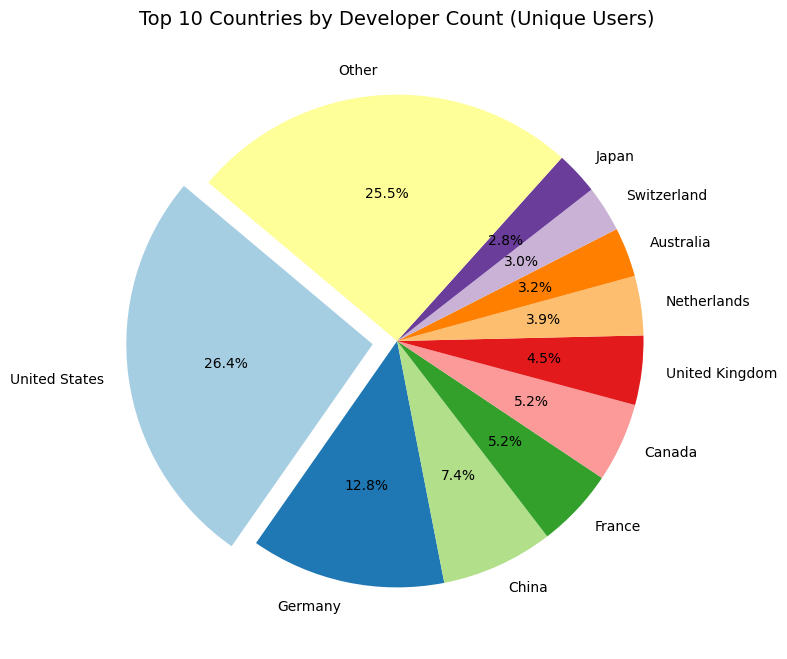

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = 'data/users_combined_info_500.csv'
data = pd.read_csv(file_path)

# Remove duplicate entries based on 'name' (assuming 'name' is the unique identifier)
unique_users = data.drop_duplicates(subset='name')

# Calculate the country distribution after removing duplicates
unique_country_distribution = unique_users['country'].value_counts()

# Select top 10 countries and aggregate others into "Other"
top_countries = unique_country_distribution.head(10)
others_count = unique_country_distribution[10:].sum()
top_countries['Other'] = others_count

# Plot the pie chart
plt.figure(figsize=(8, 8))
top_countries.plot.pie(
    autopct='%1.1f%%',  # Show percentages
    startangle=140,     # Start angle for better visual arrangement
    colors=plt.cm.Paired.colors,  # Use a color palette
    explode=[0.1] + [0] * (len(top_countries) - 1),  # Highlight the largest slice
)
plt.title('Top 10 Countries by Developer Count (Unique Users)', fontsize=14)
plt.ylabel('')  # Remove y-label for better aesthetics
plt.show()


分析主要城市的开发者密度，基本上就是统计各个城市的开发者人员数量，其中需要注意的是有一些不同的名字但是是一个城市，这一点我们可以交给gpt来解决。

C:\Users\rhw\AppData\Local\Temp\ipykernel_26564\3262669242.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_users.loc[:, 'cleaned_location'] = unique_users['location'].apply(clean_location)


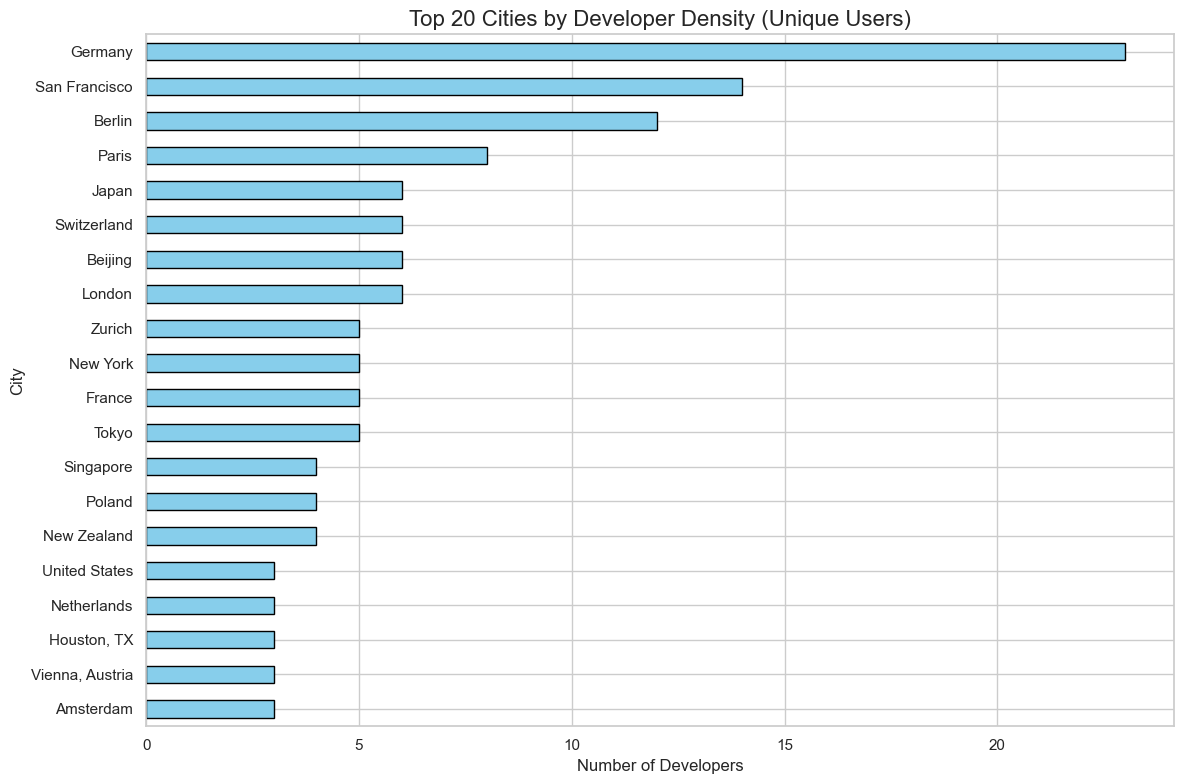

In [8]:
import pandas as pd
import re
import matplotlib.pyplot as plt

# Load the CSV file
file_path = 'data/users_combined_info_500.csv'
data = pd.read_csv(file_path)

# Remove duplicate entries based on 'name' (assuming 'name' is the unique identifier)
unique_users = data.drop_duplicates(subset='name')

# Define a mapping to clean and standardize location names
location_mapping = {
    "Berlin, Germany": "Berlin",
    "San Francisco, CA": "San Francisco",
    "Tokyo, Japan": "Tokyo",
    "Paris, France": "Paris",
    "Zurich, Switzerland": "Zurich",
    "Beijing, China": "Beijing",
    "NYC": "New York",
    "California": "San Francisco",
    "London, UK": "London",
    "New York City": "New York",
    "Los Angeles": "Los Angeles"
}

# Function to clean locations using the mapping and regex
def clean_location(location):
    # First check for mapped locations
    if location in location_mapping:
        return location_mapping[location]
    # Use regular expression to capture city names and merge them into a standard format
    location = re.sub(r"\b(San Francisco|San Jose|SF|NYC|New York City|London)\b", lambda x: x.group(0).title(), location)
    return location

# Apply the cleaning function to the 'location' column using .loc to avoid SettingWithCopyWarning
unique_users.loc[:, 'cleaned_location'] = unique_users['location'].apply(clean_location)

# Recalculate city distribution with the cleaned data
cleaned_city_distribution = unique_users['cleaned_location'].value_counts()

# Select top 20 cities with the highest developer density after cleaning
top_cleaned_cities = cleaned_city_distribution.head(20)

# Plot the city distribution as a horizontal bar chart
plt.figure(figsize=(12, 8))
top_cleaned_cities.plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('Top 20 Cities by Developer Density (Unique Users)', fontsize=16)
plt.xlabel('Number of Developers', fontsize=12)
plt.ylabel('City', fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis for better order
plt.tight_layout()
plt.show()


发现技术热点区域。我们需要根据influence进行统计。

In [9]:
import pandas as pd
import requests
import folium
from folium.plugins import HeatMap
from urllib.parse import quote_plus
import time
from IPython.display import display

# Load your data
data = pd.read_csv('data/users_combined_info_500.csv')

# Function to get coordinates using Nominatim API
def get_coordinates(city):
    # Encode city name for safe URL usage
    encoded_city = quote_plus(city)
    url = f'https://nominatim.openstreetmap.org/search?q={encoded_city}&format=json&limit=1'
    
    try:
        response = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
        # print(f"Requesting: {url}")
        
        if response.status_code == 200:
            data = response.json()
            if data:
                lat = data[0]['lat']
                lon = data[0]['lon']
                return float(lat), float(lon)
            else:
                print(f"No results found for city: {city}")
                return None
        else:
            print(f"Error with request to {city}: {response.status_code}")
            return None
    except Exception as e:
        print(f"Error with {city}: {e}")
        return None

# Fetch coordinates for all unique locations
coordinates = {}
locations = data['location'].dropna().unique()

for location in locations:
    if location not in coordinates:
        coordinates[location] = get_coordinates(location)
        time.sleep(1)  # To avoid overwhelming the API with requests

# Add coordinates to the dataset
def get_lat_lon(location):
    if location in coordinates and coordinates[location] is not None:
        return coordinates[location]
    return None, None

data['coordinates'] = data['location'].apply(get_lat_lon)

# Drop rows with missing coordinates
data_cleaned = data.dropna(subset=['coordinates'])

# Split coordinates into latitude and longitude
data_cleaned[['latitude', 'longitude']] = pd.DataFrame(data_cleaned['coordinates'].tolist(), index=data_cleaned.index)

# Group data by latitude and longitude to calculate total influence
city_influence = data_cleaned.groupby(['latitude', 'longitude'])['total_influence'].sum().reset_index()

# Prepare heatmap data
heat_data = [[row['latitude'], row['longitude'], row['total_influence']] for index, row in city_influence.iterrows()]

# Create a folium map
m = folium.Map(location=[20, 0], zoom_start=2)

# Add heatmap layer
HeatMap(heat_data).add_to(m)

# Display the map
display(m)

print("Heatmap displayed.")


No results found for city: 5 centimeters from the screen
No results found for city: Acheron, Hades
No results found for city: ::1
No results found for city: The Nearest Event Horizon
No results found for city: Europe (CET)
No results found for city: Munich, GER
No results found for city: Wah Cantt, Islamabad Pakistan
No results found for city: Earth, Milky Way
No results found for city: Netherlands, Europe
No results found for city: Mikulov, CZ ↜ Brno, CZ ↜ Brovary/Kyiv, UA
No results found for city: I’m on earth right now.
No results found for city: Everything everywhere all at once.
No results found for city: CHN, Shandong
No results found for city: GPS based...
No results found for city: $PYTHONPATH
No results found for city: Glasgow, Scotland or Lukoveček, Czech Republic
No results found for city: SPb/BG/NYC
No results found for city: </>
No results found for city: MDCC, Lyngby, Denmark
No results found for city: Guadalajara, Spain (Remote)
No results found for city: ed25519/0x156B

Heatmap displayed.


可以看出技术热点区域主要位于欧洲和美国，其次是中国。

时区分布:了解用户的时区分布，分析不同地区用户的协作时间模式。由于给出的时间具有UTC偏移量，所以得到时区的位置。

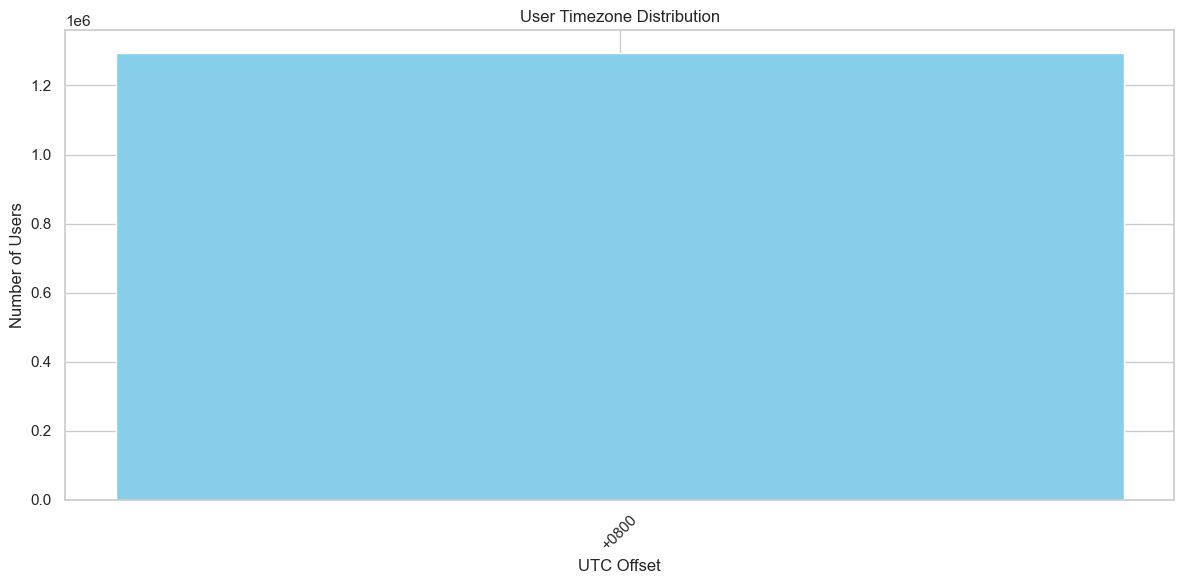

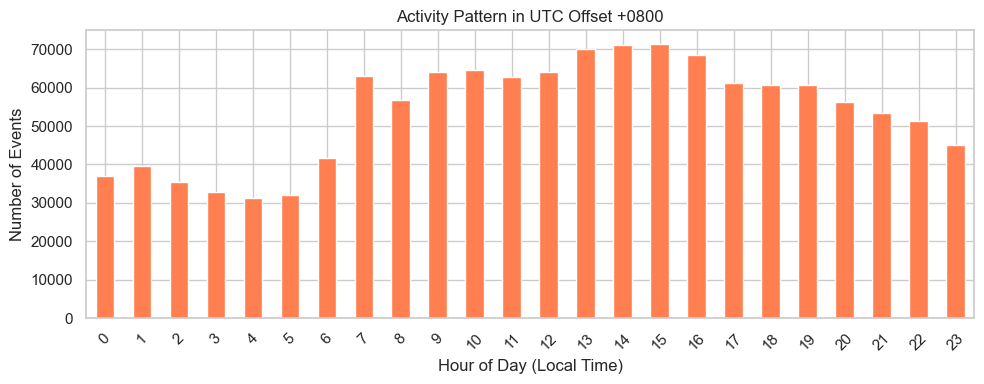

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Load data
data = pd.read_csv('data/users_combined_info_500.csv')

# Ensure 'event_time' is in datetime format
data['event_time'] = pd.to_datetime(data['event_time'], errors='coerce')

# Extract UTC offset from the datetime object
data['utc_offset'] = data['event_time'].dt.strftime('%z')  # Format as +0800, etc.

# Count timezone distribution
timezone_counts = Counter(data['utc_offset'].dropna())

# Convert to DataFrame for visualization
timezone_df = pd.DataFrame(timezone_counts.items(), columns=['UTC Offset', 'User Count']).sort_values(by='User Count', ascending=False)

# Plot timezone distribution
plt.figure(figsize=(12, 6))
plt.bar(timezone_df['UTC Offset'], timezone_df['User Count'], color='skyblue')
plt.title('User Timezone Distribution')
plt.xlabel('UTC Offset')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Extract local hour of activity
data['local_hour'] = data['event_time'].dt.hour

# Analyze activity patterns
activity_patterns = data.groupby(['utc_offset', 'local_hour']).size().unstack().fillna(0)

# Visualize activity patterns for top 5 UTC offsets
top_offsets = timezone_df['UTC Offset'].head(5)

for offset in top_offsets:
    plt.figure(figsize=(10, 4))
    activity_patterns.loc[offset].plot(kind='bar', color='coral')
    plt.title(f'Activity Pattern in UTC Offset {offset}')
    plt.xlabel('Hour of Day (Local Time)')
    plt.ylabel('Number of Events')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


可以看出时区分布只有一列，这是因为所有的偏移量都是8h从偏移量中并不能看出时区分布，我们只要分析出第二张图就好了，它给我们展示了每个小时的活动数。

协作行为分析：提交频率：统计每个用户的提交次数，识别高活跃用户和低活跃用户。这个相对简单，只需要统计后进行可视化就好了，可以通过直方图和饼状图来实现。

    

提交次数描述性统计：
count      497.000000
mean      2605.183099
std       3182.585434
min         75.000000
25%       1463.000000
50%       2026.000000
75%       2716.000000
max      37960.000000
Name: commit_count, dtype: float64


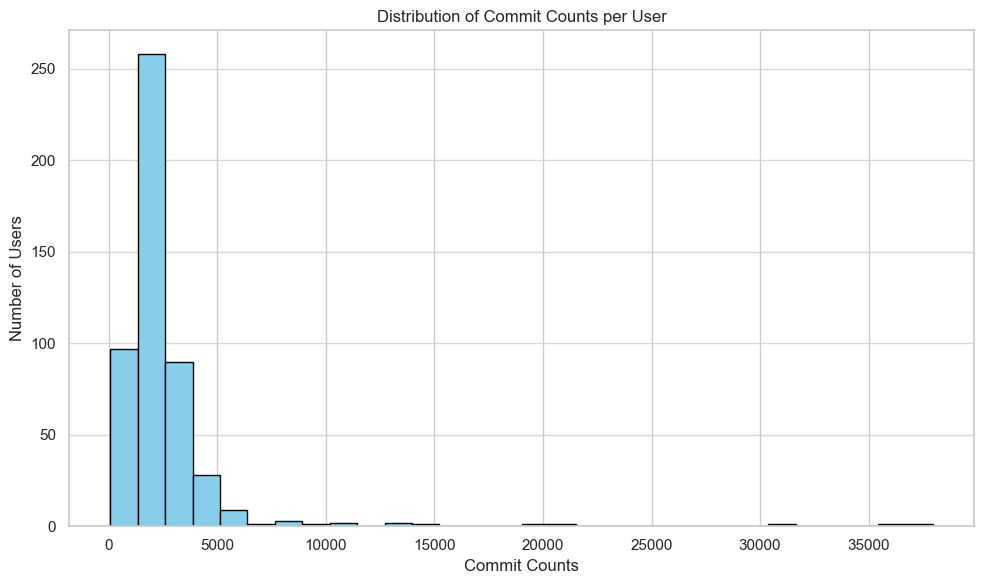

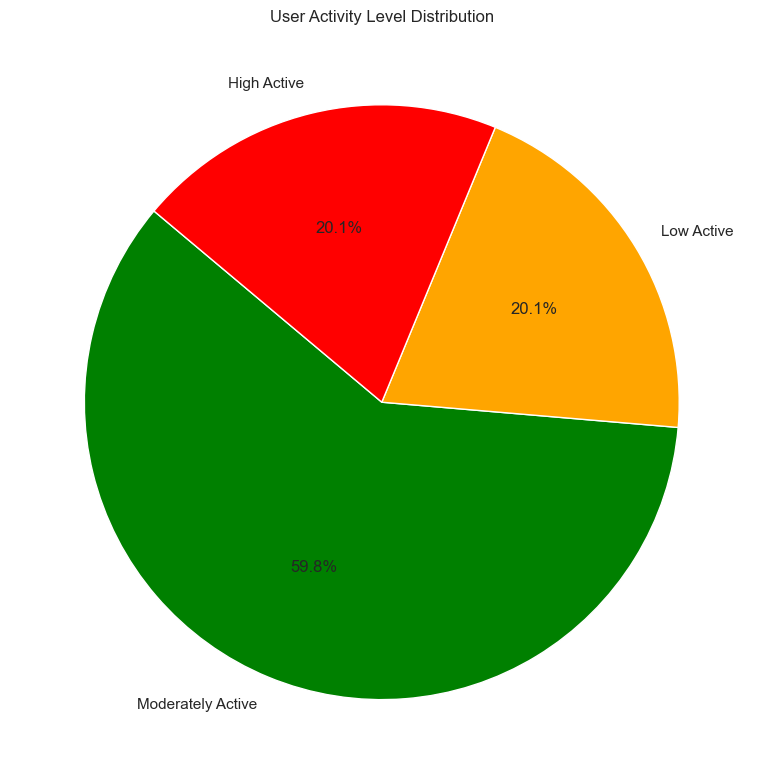

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# 加载数据
file_path = 'data/users_combined_info_500.csv'
data = pd.read_csv(file_path)

# 确保数据集中包含 'name' 和 'event_time' 列
if 'name' not in data.columns or 'event_time' not in data.columns:
    raise ValueError("数据集中需要包含 'name' 和 'event_time' 列。")

# 统计每个用户的提交次数
user_commit_counts = data.groupby('name').size().reset_index(name='commit_count')

# 查看提交次数分布
print("提交次数描述性统计：")
print(user_commit_counts['commit_count'].describe())

# 定义高活跃和低活跃用户的阈值
low_threshold = user_commit_counts['commit_count'].quantile(0.20)  # 20% 分位
high_threshold = user_commit_counts['commit_count'].quantile(0.80)  # 80% 分位

# 添加用户活跃度标签
def classify_activity(count):
    if count >= high_threshold:
        return 'High Active'
    elif count <= low_threshold:
        return 'Low Active'
    else:
        return 'Moderately Active'

user_commit_counts['activity_level'] = user_commit_counts['commit_count'].apply(classify_activity)

# 统计不同活跃度的用户数量
activity_distribution = user_commit_counts['activity_level'].value_counts()

# 可视化 1: 提交次数分布直方图
plt.figure(figsize=(10, 6))
plt.hist(user_commit_counts['commit_count'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Commit Counts per User')
plt.xlabel('Commit Counts')
plt.ylabel('Number of Users')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

# 可视化 2: 用户活跃度饼图
plt.figure(figsize=(8, 8))
activity_distribution.plot.pie(autopct='%1.1f%%', colors=['green', 'orange', 'red'], startangle=140)
plt.title('User Activity Level Distribution')
plt.ylabel('')
plt.tight_layout()
plt.show()


对于两个有趣的纬度洞察：我们可以统计一下各个操作的占比和数量，来了解一下用户们进行什么类型的操作最多。我们还可以统计一下每个用户有没有对哪种行为的偏好，来统计对各个类型的操作有偏好的用户的占比。

   user_id    name     location  total_influence        country   event_type  \
0   663432  bdraco  Houston, TX      1776.967163  United States  CreateEvent   
1   663432  bdraco  Houston, TX      1776.967163  United States  CreateEvent   
2   663432  bdraco  Houston, TX      1776.967163  United States  CreateEvent   
3   663432  bdraco  Houston, TX      1776.967163  United States  CreateEvent   
4   663432  bdraco  Houston, TX      1776.967163  United States  CreateEvent   

  event_action                 event_time  
0        added  2024-11-26 20:28:37+08:00  
1        added  2024-11-26 20:42:57+08:00  
2        added  2024-11-27 04:10:46+08:00  
3        added  2024-11-27 17:43:50+08:00  
4        added  2024-11-27 19:56:34+08:00  


C:\Users\rhw\AppData\Local\Temp\ipykernel_26564\3634641408.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0, 0], x=event_type_counts.index, y=event_type_counts.values, palette="viridis")
C:\Users\rhw\AppData\Local\Temp\ipykernel_26564\3634641408.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0, 1], x=event_action_counts.index, y=event_action_counts.values, palette="viridis")


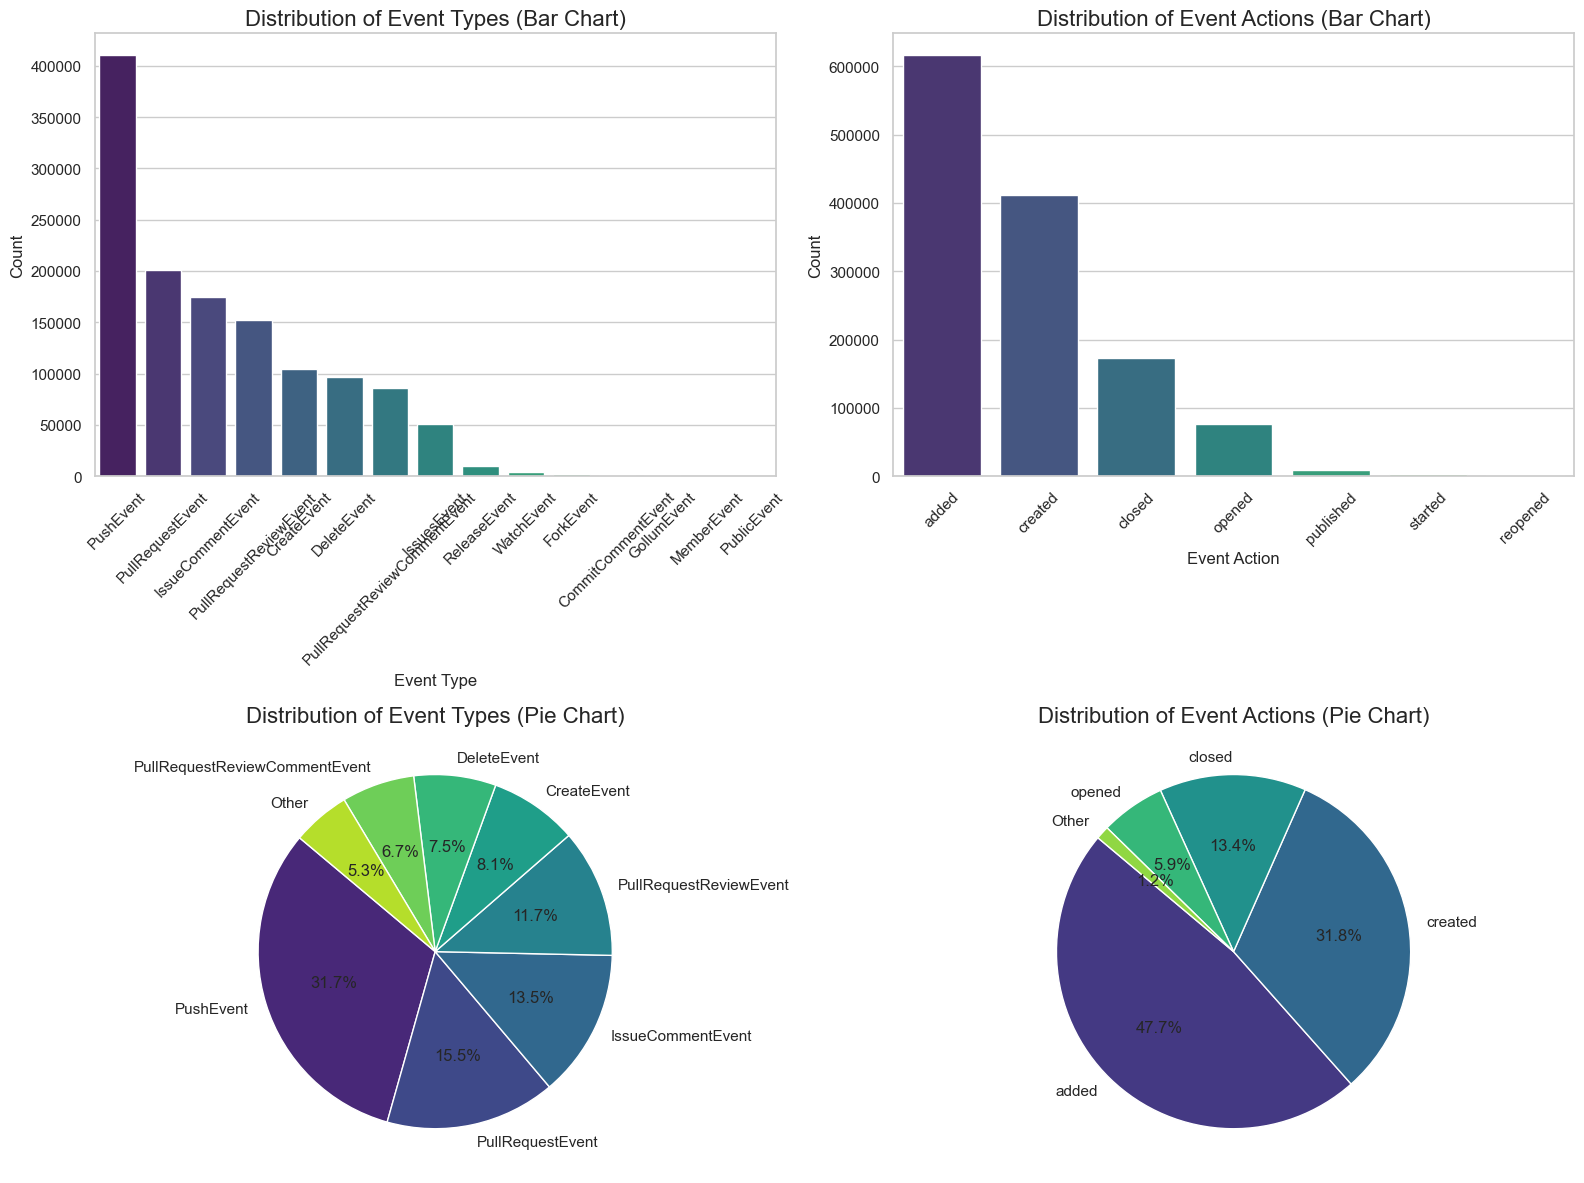

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 读取数据集
file_path = "data/users_combined_info_500.csv"
data = pd.read_csv(file_path)

# 检查数据
print(data.head())

# 统计用户行为分布
event_type_counts = data['event_type'].value_counts()
event_action_counts = data['event_action'].value_counts()

def merge_small_categories(series, threshold=0.05):
    """
    合并小于阈值的类别为 'Other'
    """
    total = series.sum()
    other_threshold = total * threshold
    large_categories = series[series >= other_threshold]
    small_categories_sum = series[series < other_threshold].sum()
    
    if small_categories_sum > 0:
        large_categories['Other'] = small_categories_sum
    
    return large_categories

# 合并小于 5% 的块
event_type_merged = merge_small_categories(event_type_counts, threshold=0.05)
event_action_merged = merge_small_categories(event_action_counts, threshold=0.05)

# 设置绘图风格
sns.set(style="whitegrid")

# 创建图形对象
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 绘制 event_type 分布柱状图
sns.barplot(ax=axes[0, 0], x=event_type_counts.index, y=event_type_counts.values, palette="viridis")
axes[0, 0].set_title("Distribution of Event Types (Bar Chart)", fontsize=16)
axes[0, 0].set_xlabel("Event Type", fontsize=12)
axes[0, 0].set_ylabel("Count", fontsize=12)
axes[0, 0].tick_params(axis='x', rotation=45)

# 绘制 event_action 分布柱状图
sns.barplot(ax=axes[0, 1], x=event_action_counts.index, y=event_action_counts.values, palette="viridis")
axes[0, 1].set_title("Distribution of Event Actions (Bar Chart)", fontsize=16)
axes[0, 1].set_xlabel("Event Action", fontsize=12)
axes[0, 1].set_ylabel("Count", fontsize=12)
axes[0, 1].tick_params(axis='x', rotation=45)

# 绘制 event_type 分布饼状图
axes[1, 0].pie(event_type_merged.values, labels=event_type_merged.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis", len(event_type_merged)))
axes[1, 0].set_title("Distribution of Event Types (Pie Chart)", fontsize=16)

# 绘制 event_action 分布饼状图
axes[1, 1].pie(event_action_merged.values, labels=event_action_merged.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis", len(event_action_merged)))
axes[1, 1].set_title("Distribution of Event Actions (Pie Chart)", fontsize=16)

# 调整布局并显示图像
plt.tight_layout()
plt.show()


   user_id    name     location  total_influence        country   event_type  \
0   663432  bdraco  Houston, TX      1776.967163  United States  CreateEvent   
1   663432  bdraco  Houston, TX      1776.967163  United States  CreateEvent   
2   663432  bdraco  Houston, TX      1776.967163  United States  CreateEvent   
3   663432  bdraco  Houston, TX      1776.967163  United States  CreateEvent   
4   663432  bdraco  Houston, TX      1776.967163  United States  CreateEvent   

  event_action                 event_time  
0        added  2024-11-26 20:28:37+08:00  
1        added  2024-11-26 20:42:57+08:00  
2        added  2024-11-27 04:10:46+08:00  
3        added  2024-11-27 17:43:50+08:00  
4        added  2024-11-27 19:56:34+08:00  
用户偏好行为分布：
preferred_action
added      59.959759
created    39.034205
closed      0.804829
opened      0.201207
Name: proportion, dtype: float64


C:\Users\rhw\AppData\Local\Temp\ipykernel_26564\214626907.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=action_preference_distribution.index, y=action_preference_distribution.values, palette="viridis")


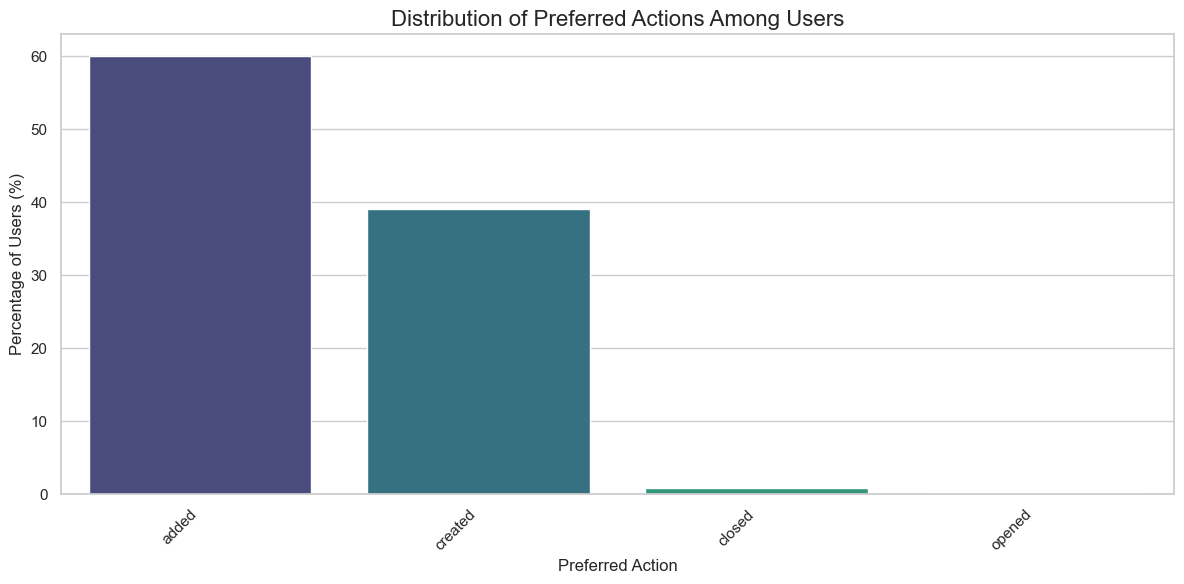

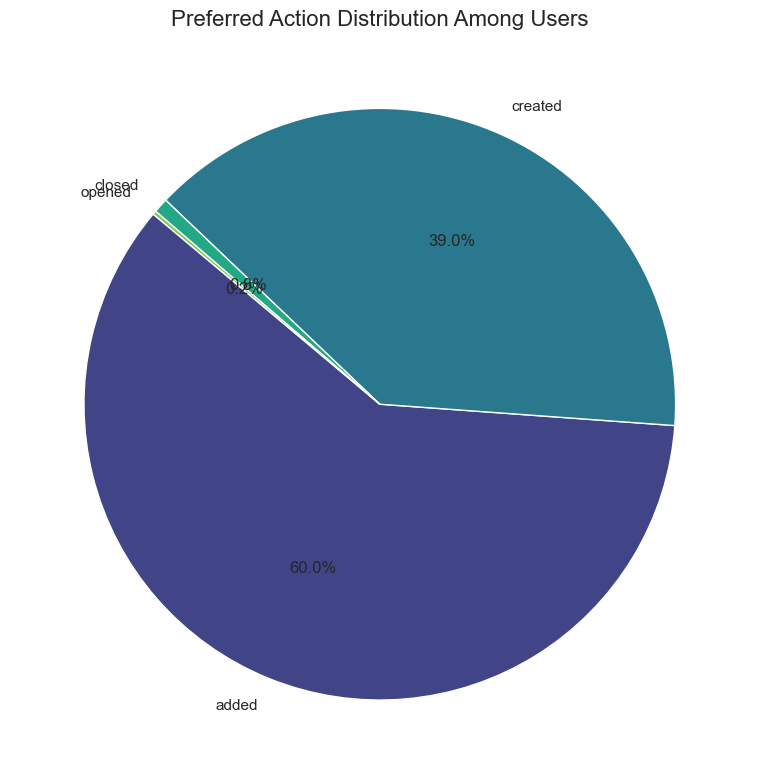

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 读取数据
file_path = "data/users_combined_info_500.csv"
data = pd.read_csv(file_path)

# 检查数据
print(data.head())

# 统计每位用户对每种行为的操作次数
user_action_counts = data.groupby(['name', 'event_action']).size().reset_index(name='action_count')

# 计算每位用户的总操作次数
total_actions_per_user = user_action_counts.groupby('name')['action_count'].sum().reset_index()
total_actions_per_user.columns = ['name', 'total_actions']

# 合并数据以计算偏好比例
user_action_counts = pd.merge(user_action_counts, total_actions_per_user, on='name')
user_action_counts['preference_ratio'] = user_action_counts['action_count'] / user_action_counts['total_actions']

# 找出每位用户最偏好的行为
user_preferences = user_action_counts.loc[user_action_counts.groupby('name')['preference_ratio'].idxmax()]
user_preferences = user_preferences[['name', 'event_action', 'preference_ratio']].reset_index(drop=True)
user_preferences.columns = ['name', 'preferred_action', 'preference_ratio']

# 汇总用户偏好行为的分布
action_preference_distribution = user_preferences['preferred_action'].value_counts(normalize=True) * 100

# 打印分析结果
print("用户偏好行为分布：")
print(action_preference_distribution)

# 可视化用户偏好行为分布（条形图）
plt.figure(figsize=(12, 6))
sns.barplot(x=action_preference_distribution.index, y=action_preference_distribution.values, palette="viridis")
plt.title("Distribution of Preferred Actions Among Users", fontsize=16)
plt.xlabel("Preferred Action", fontsize=12)
plt.ylabel("Percentage of Users (%)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 可视化用户偏好行为分布（饼状图）
plt.figure(figsize=(8, 8))
plt.pie(action_preference_distribution.values, labels=action_preference_distribution.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis", len(action_preference_distribution)))
plt.title("Preferred Action Distribution Among Users", fontsize=16)
plt.tight_layout()
plt.show()
